# Virtual Screening

<div class="alert alert-block alert-info">
<Strong>Objectives</strong>

- Perform virtual screening against PubChem using ligand-based approach
- Apply filters to prioritize virtual screening hit list.
- Learn how to use pandas' data frame.

In this notebook, we perform virtual screening against PubChem using a set of known ligands for muscle glycogen phosphorylase.  Compound filters will be applied to identify drug-like compounds and unique structures in terms of connectivity SMILES (no stereochemistry encoded) will be selected to remove redundant structures.  For some top-ranked compounds in the list, their binding mode will be predicted using machine learning (which will be covered in Module 10: Supervised machine learning).

# 1. PubChem Helper Functions
In this section, we will create a small library of reusable helper functions that make it safer and more reliable to download data from PubChem’s PUG-REST API. Large batch requests or repeated API calls can fail for many reasons, network delays, timeouts, server errors, or rate limits, so it is important to follow best practices such as retry logic, timeouts, progress bars, and clear error messages. Each helper function below is designed to do one job well, with clean return types and consistent behavior. We will use these functions throughout the rest of the notebook whenever we query PubChem for similarity searches, identity matches, or bulk property downloads.


## Helper Functions Overview

| Function Name                       | Purpose                                                                                | Key Features                                                         |
| ----------------------------------- | -------------------------------------------------------------------------------------- | -------------------------------------------------------------------- |
| **`pubchem_post()`**                | Safely performs POST requests to PubChem (used for fastsimilarity, fastidentity, etc.) | Retries, timeouts, backoff, clear error messages                     |
| **`pubchem_get()`**                 | Safely performs GET requests to PubChem (used for property lookups)                    | Retries, timeouts, backoff, consistent text return                   |
| **`pubchem_fastsimilarity()`**      | Runs PubChem’s **fastsimilarity_2d** search for a SMILES string                        | Returns list of CIDs, wraps POST helper, handles parsing errors      |
| **`pubchem_fastidentity()`**        | Runs PubChem’s **fastidentity** search for exact or related structures                 | Allows multiple identity types, safe POST, clean CID list            |
| **`pubchem_properties_for_cids()`** | Downloads molecular properties for large lists of CIDs in chunks                       | Automatic batching, CSV concatenation, progress bars, error tracking |
| **`chunk_list()`**                  | Splits large lists (e.g. CIDs) into manageable chunks for batch API requests           | Simple batching, prevents overly large URLs, improves reliability    |


In [5]:
import time
import requests
from tqdm import tqdm

# Base URL for PUG REST
PUG = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"


In [6]:
def pubchem_post(url, data=None, retries=3, timeout=20, base_delay=2):
    """
    Generic helper for PubChem POST requests with retry/backoff.

    Returns:
        response.text (string) on success,
        None on failure.
    """
    for attempt in range(1, retries + 1):
        try:
            r = requests.post(url, data=data, timeout=timeout)
            r.raise_for_status()
            return r.text

        except Exception as e:
            print(f"[Warning] POST attempt {attempt}/{retries} failed.")
            print(f"         URL: {url}")
            print(f"         Error: {type(e).__name__}: {e}")
            time.sleep(base_delay * attempt)

    print(f"[Error] All POST attempts failed for URL: {url}")
    return None


In [7]:
def pubchem_get(url, retries=3, timeout=20, base_delay=2):
    """
    Generic helper for PubChem GET requests with retry/backoff.

    Returns:
        response.text (string) on success,
        None on failure.
    """
    for attempt in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout)
            r.raise_for_status()
            return r.text

        except Exception as e:
            print(f"[Warning] GET attempt {attempt}/{retries} failed.")
            print(f"         URL: {url}")
            print(f"         Error: {type(e).__name__}: {e}")
            time.sleep(base_delay * attempt)

    print(f"[Error] All GET attempts failed for URL: {url}")
    return None


In [8]:
def pubchem_fastsimilarity(smiles, threshold=90):
    """
    Query PubChem fastsimilarity_2d for a SMILES string.

    Returns:
        list of CIDs (ints) or empty list on failure.
    """
    url = f"{PUG}/compound/fastsimilarity_2d/smiles/cids/txt?Threshold={threshold}"
    data = {"smiles": smiles}

    text = pubchem_post(url, data=data)
    if text is None:
        return []

    try:
        return [int(x) for x in text.split()]
    except ValueError:
        print("[Error] Could not parse CIDs:", text)
        return []


In [9]:
def pubchem_fastidentity(smiles, identity_type="same_connectivity"):
    """
    Query PubChem fastidentity for exact, tautomer, scaffold, or connectivity matches.

    Returns:
        list of CIDs (ints) or empty list on failure.
    """
    url = (
        f"{PUG}/compound/fastidentity/smiles/cids/txt"
        f"?identity_type={identity_type}"
    )
    data = {"smiles": smiles}

    text = pubchem_post(url, data=data)
    if text is None:
        print(f"[Error] FastIdentity failed for SMILES: {smiles}")
        return []

    try:
        return [int(x) for x in text.split()]
    except ValueError:
        print(f"[Error] Could not parse CIDs for SMILES {smiles}: {text}")
        return []


In [10]:
#Batch properties lookup
def pubchem_properties_for_cids(
    cid_list,
    properties=[
        "HBondDonorCount", "HBondAcceptorCount",
        "MolecularWeight", "XLogP",
        "ConnectivitySMILES", "SMILES"
    ],
    chunk_size=100,
    sleep_time=0.25
):
    """
    Retrieve PubChem properties for many CIDs using chunking.

    Returns:
        (csv_text, failed_chunks)
    """
    from math import ceil

    num_chunks = ceil(len(cid_list) / chunk_size)
    failed = []
    csv_output = ""

    print(f"# CIDs: {len(cid_list)}, chunks: {num_chunks}")

    props = ",".join(properties)

    for i in tqdm(range(num_chunks)):
        chunk = cid_list[i * chunk_size: (i + 1) * chunk_size]
        cid_str = ",".join(str(x) for x in chunk)

        url = f"{PUG}/compound/cid/{cid_str}/property/{props}/csv"

        text = pubchem_get(url)
        if text is None:
            failed.append(i)
            continue

        # Proper CSV concatenation
        lines = text.splitlines()
        if i == 0:
            csv_output = "\n".join(lines)
        else:
            csv_output += "\n" + "\n".join(lines[1:])  # skip header on later chunks

        time.sleep(sleep_time)

    return csv_output, failed


In [11]:
# Chunk  list helper function
def chunk_list(lst, size=100):
    """Yield successive chunks of a list."""
    for i in range(0, len(lst), size):
        yield lst[i:i + size]


## File-Saving Helper Functions
| Function Name         | Purpose                                                             | Key Features                                                                      |
| --------------------- | ------------------------------------------------------------------- | --------------------------------------------------------------------------------- |
| **`make_filename()`** | Generates a timestamped filename using a given prefix and extension | Ensures unique filenames, includes date/time metadata, avoids overwriting         |
| **`save_csv()`**      | Saves a CSV text string to the `downloads/` folder                  | Uses timestamped filenames, UTF-8 encoding, prints saved path for reproducibility |
| **`save_json()`**     | Saves any Python object (dict/list) as a JSON file                  | Pretty, human-readable JSON; timestamped filenames; ensures reproducible outputs  |
| **`save_text()`**     | Saves plain text (logs, raw API responses, CSV fragments, etc.)     | Flexible format; user controls prefix/extension; timestamped filenames            |


In [1]:
# versioned timestamped filename
import os
from datetime import datetime

def make_filename(prefix, ext="csv", folder="downloads"):
    """
    Generate a filename of the form:
        prefix_YYYYMMDD_vN.ext
    where vN increments if files already exist for that day.
    """
    os.makedirs(folder, exist_ok=True)

    # Today's date (no time)
    date_str = datetime.now().strftime("%Y%m%d")

    # Base filename without version
    base = f"{prefix}_{date_str}"

    # Find existing versions
    existing = [
        fname for fname in os.listdir(folder)
        if fname.startswith(base) and fname.endswith("." + ext)
    ]

    # Determine next version number
    version = len(existing) + 1  # v1, v2, v3, ...

    # Build the final filename
    filename = f"{base}_v{version}.{ext}"

    return f"{folder}/{filename}"


In [2]:
# save as CSV
def save_csv(text, prefix="pubchem_data", folder="downloads"):
    """
    Save text (CSV-format) to disk with a generated name.
    Returns the file path.
    """
    fname = make_filename(prefix, ext="csv", folder=folder)
    with open(fname, "w", encoding="utf-8") as f:
        f.write(text)
    print(f"[Saved] CSV file written to: {fname}")
    return fname


In [3]:
# save as json
import json

def save_json(obj, prefix="pubchem_json", folder="downloads"):
    """
    Save a Python object as JSON to disk.
    Returns the file path.
    """
    fname = make_filename(prefix, ext="json", folder=folder)
    with open(fname, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2)
    print(f"[Saved] JSON file written to: {fname}")
    return fname


In [4]:
# save as text
def save_text(text, prefix="output", ext="txt"):
    """Save a raw text string to downloads/ with timestamp."""
    filename = make_filename(prefix, ext)
    filepath = f"downloads/{filename}"
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(text)
    print(f"[Saved] Text written to: {filepath}")
    return filepath


# 2. Read known ligands from a file.
As a starting point, let's download a set of known ligands against muscle glycogen phosphorylase.  These data are obtained from the DUD-E (Directory of Useful Decoys, Enhanced) data sets (http://dude.docking.org/), which contain known actives and inactives for 102 protein targets.  The DUD-E sets are widely used in benchmarking studies that compare the performance of different virtual screening approaches (https://doi.org/10.1021/jm300687e).

Glycogen phosphorylase is an enzyme that breaks down glycogen, a highly branched polymer of glucose used by the body to store readily accessible energy. Humans express three closely related isoforms of this enzyme—muscle (PYGM), liver (PYGL), and brain (PYGB)—each tuned to the energy needs of its respective tissue. In muscle, glycogen phosphorylase releases glucose units that enter the cell’s energy-producing pathways (glycolysis → Krebs cycle), making it essential for rapid ATP generation during exercise.

The structure we will use for docking, 1C8K (Protein Data Bank ID), is a high-resolution crystal structure showing how small molecules bind to muscle glycogen phosphorylase. Before working with potential ligands that interact with PYGM, we will download the protein structure directly from the Protein Data Bank. To visualize it inside a Jupyter notebook, you will need to install the py3Dmol package if it is not already present in your Conda environment..
```bash
conda install -c conda-forge py3dmol
```

The following code downloads the modern mmCIF file for 1C8K and displays it using py3Dmol.


In [2]:
import requests
import py3Dmol

pdb_id = "1C8K"
url = f"https://files.rcsb.org/download/{pdb_id}.cif"

response = requests.get(url)
response.raise_for_status()
cif_block = response.text

view = py3Dmol.view(width=600, height=400)
view.addModel(cif_block, "cif")
view.setStyle({"cartoon": {"color": "spectrum"}})
view.setStyle({"hetflag": True}, {"stick": {}})
view.zoomTo()
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
# to download the legacy pdb file:
import requests
import py3Dmol

pdb_id = "1C8K"
url = f"https://files.rcsb.org/download/{pdb_id}.pdb"

response = requests.get(url)
response.raise_for_status()  # will error cleanly if download fails
pdb_block = response.text

# Create a 3D viewer
view = py3Dmol.view(width=600, height=400)
view.addModel(pdb_block, "pdb")

# Pretty default: cartoon for protein, sticks for ligand
view.setStyle({"cartoon": {"color": "spectrum"}})
view.setStyle({"hetflag": True}, {"stick": {}})

view.zoomTo()
view.show()


Go to the DUD-E target page (http://dude.docking.org/targets) and find muscle glycogen phosphorylase (Target Name: PYGM, PDB ID: 1c8k) from the target list.  Clicking the target name "PYGM" directs you to the page that lists various files (http://dude.docking.org/targets/pygm).  Download file "**actives_final.ism**", which contains the SMILES strings of known actives.  Rename the file name as "**pygm_1c8k_actives.ism**".  \[Open the file in a text viewer/editor to check the format of this file\].

In [10]:
import pandas as pd

In [4]:
colnames = ['smiles','DUD-E ID', 'CHEMBL_ID']
df_act = pd.read_csv("pygm_1c8k_actives.ism", sep=" ", names=colnames)
df_act.head(5)

,smiles,DUD-E ID,CHEMBL_ID
0,c1ccc2cc(c(cc2c1)NC(=O)c3cc(ccn3)N(=O)=O)Oc4cc...,220668,CHEMBL134802
1,CC1=C(C(C(=C(N1Cc2ccc(cc2)Cl)C(=O)O)C(=O)O)c3c...,189331,CHEMBL115651
2,CCN1C(=C(C(C(=C1C(=O)O)C(=O)O)c2ccccc2Cl)C(=O)...,188996,CHEMBL113736
3,c1cc(c(c(c1)F)NC(=O)c2cc(ccn2)N(=O)=O)Oc3ccc(c...,219845,CHEMBL133911
4,CC1=C(C(C(=C(N1Cc2cccc(c2)N(=O)=O)C(=O)O)C(=O)...,189034,CHEMBL423509


In [5]:
print(len(df_act))    # Show how many structures are in the "data frame"

77


## 2. Similarity Search against PubChem

Now, let's perform similarity search against PubChem using each known active compound as a query.  There are a few things to mention in this step:

- The SMILES were obtained from the DUD-E database. Since there are multiple ways to generate SMILES, PubChem will run an algorithm to convert the SMILES in the query to the SMILES in the PubChem database.

- The SMILES string is available for each query compound. This string will be used to specify the input structure, so HTTP POST should be used.  (Please review lecture02-structure-inputs.ipynb)

- During PubChem's similarity search, molecular similarity is evaluated using the **PubChem fingerprints** and **Tanimoto** coefficient.  By default, similarity search will return compounds with Tanimoto scores of **0.9 or higher**.  While we will use the default threshold in this practice, it is noteworthy that it is adjustable.  If you use a higher threshold (e.g., 0.99), you will get a fewer hits, which are too similar to the query compounds.  If you use a lower threshold (e.g., 0.88), you will get more hits, but they will include more false positives.

- PubChem's similarity search does **not** return the similarity scores between the query and hit compounds.  Only the hit compound list is returned, which makes it difficult to rank the hit compounds for compound selection.  To address this issue, for each hit compound, we compute **the number of query compounds that returned that compound as a hit.**  \[Because we are using multiple query compounds for similarity search, it is possible for different query compounds to return the same compound as a hit.  That is, the hit compound may be similar to multiple query compounds.  The underlying assumption is that hit compounds returned multiple times from different queries are more likely to be active than those returned only once from a single query.\]

- Add "time.sleep()" to avoid overloading PubChem servers and getting blocked.

In [12]:
smiles_act = df_act.smiles.to_list()

In [13]:
from tqdm import tqdm

# Convert the DUDE actives to a Python list of SMILES
smiles_act = df_act.smiles.to_list()

cids_hit = {}   # {cid: count_of_occurrences}

print(f"# Running fast similarity search on {len(smiles_act)} DUDE actives...")
print("# PubChem default similarity threshold = 90 (Tanimoto 0.9)")
print()

for smi in tqdm(smiles_act, desc="FastSimilarity"):
    
    # Query PubChem fastsimilarity (safe POST with retries)
    hits = pubchem_fastsimilarity(smi, threshold=90)
    
    # hits will be [] on failure
    if len(hits) == 0:
        print(f"[Warning] No CIDs returned for SMILES: {smi}")
    
    # Count each CID hit
    for cid in hits:
        cids_hit[cid] = cids_hit.get(cid, 0) + 1

print("\n# Similarity search complete.")
print(f"# Total unique CIDs returned: {len(cids_hit)}")


# Running fast similarity search on 77 DUDE actives...
# PubChem default similarity threshold = 90 (Tanimoto 0.9)



FastSimilarity: 100%|██| 77/77 [08:32<00:00,  6.66s/it]


# Similarity search complete.
# Total unique CIDs returned: 28883


In [21]:
print(type(cids_hit))
len(cids_hit)    # Show the number of compounds returned from any query.

<class 'dict'>


28883

Because the data is in a dictionary we will save it as a json file

In [19]:
# choose own descriptive prefix
prefix = "DUDE_PYGM_fastsimilarity_actives"

# Call save_json 
save_json(cids_hit, prefix=prefix)


[Saved] JSON file written to: downloads/DUDE_PYGM_fastsimilarity_actives_20251202_094059.json


'downloads/DUDE_PYGM_fastsimilarity_actives_20251202_094059.json'

If in the future you need to open this file, you can run the following code
```python
import json

# Path to the saved file (copy/paste yours)
filepath = "downloads/DUDE_PYGM_fastsimilarity_actives_20251202_094059.json"

with open(filepath, "r", encoding="utf-8") as f:
    cids_hits = json.load(f)

print(f"Loaded {len(cids_hits)} CIDs into cids_hits.")
```


In [22]:
import json

# Path to the saved file (copy/paste yours)
filepath = "downloads/DUDE_PYGM_fastsimilarity_actives_20251202_094059.json"

with open(filepath, "r", encoding="utf-8") as f:
    cids_hits = json.load(f)

print(f"Loaded {len(cids_hits)} CIDs into cids_hits.")


Loaded 28883 CIDs into cids_hits.


In [23]:
print(type(cids_hit))
len(cids_hit)    # Show the number of compounds returned from any query.

<class 'dict'>


28883

In the above code cells, the returned hits are stored in a dictionary, along with the number of times they are returned.  Let's print the top 10 compounds that are returned the most number of times from the search.

In [24]:
sorted_by_freq = [ (v, k) for k, v in cids_hit.items() ]
sorted_by_freq.sort(reverse=True)

for v, k in enumerate(sorted_by_freq) :

    if v == 10 : 
        break
    
    print(v, k) # Print (frequency, CID)
    

0 (16, 44354348)
1 (15, 44354370)
2 (15, 44354349)
3 (15, 44354322)
4 (13, 44357907)
5 (12, 44357938)
6 (12, 44357937)
7 (12, 44354455)
8 (12, 44354454)
9 (12, 44354362)


## 3. Exclude the query compounds from the hits

In the previous step, we repeated similarity searches using multiple query molecules.  This may result in a query molecule being returned as a hit from similarity search using another query molecule.  Therefore, we want to check if the hit compound list has any query compounds and if any, we want to remove them.  Below, we search PubChem for compounds identical to the query molecules and remove them from the hit compound list.<p>
Note that the identity_type parameter in the PUG-REST request is set to "**same_connectivity**", which will return compounds with the same connectivity with the query molecule (ignoring stereochemistry and isotope information).  The default for this parameter is "same_stereo_isotope", which returns compounds with the same stereochemistry AND isotope information.

In [27]:
from tqdm import tqdm

# The DUDE active ligands as a list of SMILES
smiles_act = df_act.smiles.to_list()

cids_query = {}   # {cid: count_of_occurrences}

print(f"# Running fast identity search on {len(smiles_act)} DUDE actives...")
print("# PubChem identity_type = same_connectivity")
print()

for smi in tqdm(smiles_act, desc="FastIdentity"):
    
    # Query PubChem using your helper function
    hits = pubchem_fastidentity(smi, identity_type="same_connectivity")
    
    # hits will be [] on failure
    if len(hits) == 0:
        print(f"[Warning] No identity CIDs returned for SMILES: {smi}")
    
    # Count each CID (identity matches)
    for cid in hits:
        cids_query[cid] = cids_query.get(cid, 0) + 1

print("\n# Fast identity search complete.")
print(f"# Total unique CIDs returned: {len(cids_query)}")


# Running fast identity search on 77 DUDE actives...
# PubChem identity_type = same_connectivity



FastIdentity: 100%|████| 77/77 [07:20<00:00,  5.72s/it]


# Fast identity search complete.
# Total unique CIDs returned: 138


Now remove the query compounds from the hit list (if they are found in the list)

In [28]:
for mycid in cids_query.keys() :
    
    cids_hit.pop(mycid, None)

In [29]:
len(cids_hit)

28745

Print the top 10 compounds in the current hit list and compare them with the old ones.

In [30]:
sorted_by_freq = [ (v, k) for k, v in cids_hit.items() ]
sorted_by_freq.sort(reverse=True)

for v, k in enumerate(sorted_by_freq) :
    
    if v == 10 : 
        break
    
    print(v, k)    # Print (frequency, CID)


0 (12, 11779854)
1 (11, 168140615)
2 (11, 166196489)
3 (11, 141135915)
4 (11, 118078858)
5 (11, 93077065)
6 (11, 93077064)
7 (11, 53013349)
8 (11, 51808718)
9 (11, 45369696)


<div class="alert alert-block alert-warning">
<Strong>Check Your Understanding</strong>

- How many molecules were returned from the original query?
- How many molecules were returned were the query compounds?
- Does the number of molecules in len(cids_hits) confirm you have removed the query compounds from the original list?
- Have the top 10 compounds in hit list changed? Does this confirm you have removed the query compounds from the original list?

In [31]:
# choose own descriptive prefix
prefix = "DUDE_PYGM_fastsimilarity_actives_unique"

# Call save_json 
save_json(cids_hit, prefix=prefix)


[Saved] JSON file written to: downloads/DUDE_PYGM_fastsimilarity_actives_unique_20251202_102442.json


'downloads/DUDE_PYGM_fastsimilarity_actives_unique_20251202_102442.json'

## 4. Filtering out non-drug-like compounds
We want to identify problematic compounds to exclude from virtual screening. These are molecules that are not absorbed well and may not be good for an orally administered drug. 

A team at Pfizer led by Christopher Lipinski evaluated 2245 compounds that reached phase II clinical trials and determined most orally administered drugs are relatively small and moderately lipophilic. This lead to the <a href ="https://pubmed.ncbi.nlm.nih.gov/11259830/">"Rule of 5" for "drug-likeness"</a> and helps determine whether a molecule has good solubility and permeability. The team suggests that a good lead follow has characteristics based on the number 5:

- Molecular weight < 500
- no more than 5 hydrogen bond donors
- no more than 10 hydrogen bond acceptors
- a calculated octanol-water partician coefficent (XLogP) <5

In this step, non-drug-like compounds are filtered out from the list using these criteria.  To do that, these four molecular properties are downloaded from PubChem and stored in CSV.

In [2]:
# Open the saved json file "downloads/DUDE_PYGM_fastsimilarity_actives_unique_20251202_102442.json" as a dictionary
import json

filepath = "downloads/DUDE_PYGM_fastsimilarity_actives_unique_20251202_102442.json"

with open(filepath, "r", encoding="utf-8") as f:
    cids_hit = json.load(f)

print(f"Loaded {len(cids_hit)} CIDs into cids_hit.")


Loaded 28745 CIDs into cids_hit.


In [16]:
# Convert dict keys to a list
cid_list = list(cids_hit.keys())

# Download properties
csv_text, failed_chunks = pubchem_properties_for_cids(cid_list, chunk_size=100)

# Show failures (if any)
if failed_chunks:
    print("\nThe following chunks failed:")
    for idx, code in failed_chunks:
        print(f" - Chunk {idx}, status/error: {code}")
else:
    print("\nAll chunks completed successfully!")

# Save file if available
if csv_text:
    save_csv(csv_text, prefix="DUDE_PYGM_properties")


# CIDs: 28745, chunks: 288


100%|████████████████| 288/288 [29:23<00:00,  6.12s/it]


All chunks completed successfully!
[Saved] CSV file written to: downloads/DUDE_PYGM_properties_20251203_222507.csv


In [ ]:
# === REPORT FAILURES ===
if failed_chunks:
    print("\nThe following chunks failed:")
    for idx, code in failed_chunks:
        print(f" - Chunk {idx}, status/error: {code}")
else:
    print("\nAll chunks completed successfully!")


In [13]:
import pandas as pd

df_raw = pd.read_csv("downloads/DUDE_PYGM_properties_20251203_222507.csv")

df_raw.head()


,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,ConnectivitySMILES,SMILES
0,1731763,0,5,454.0,5.5,CCOC(=O)C1=C(N(C(=C(C1C2=CC=C(C=C2)Cl)C(=O)OCC...,CCOC(=O)C1=C(N(C(=C(C1C2=CC=C(C=C2)Cl)C(=O)OCC...
1,21795259,0,5,454.0,5.5,CCOC(=O)C1=C(N(C(=C(C1C2=CC=CC=C2Cl)C(=O)OCC)C...,CCOC(=O)C1=C(N(C(=C(C1C2=CC=CC=C2Cl)C(=O)OCC)C...
2,155906259,0,5,439.9,6.3,CCOC(=O)C1=C(N(C(=C(C1C2=CC=CC=C2Cl)C(=O)OC)C)...,CCOC(=O)C1=C(N(C(=C(C1C2=CC=CC=C2Cl)C(=O)OC)C)...
3,9910160,3,4,422.9,4.4,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...
4,9823695,3,4,424.9,4.6,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...


Downloaded data (in CSV) are loaded into a pandas data frame.

If you want to read directly from the string
```python
from io import StringIO

csv_file = StringIO(csv)

df_raw = pd.read_csv(csv_file, sep=",")

df_raw.shape    # Show the shape (dimension) of the data frame
```

Note that some compounds do not have computed XLogP values (because XLogP algorithm cannot handle inorganic compounds, salts, and mixtures) and we want to remove them.

In [15]:
df_raw.isna().sum()    # Check if there are any NULL values.

CID                     0
HBondDonorCount         0
HBondAcceptorCount      0
MolecularWeight         0
XLogP                 979
ConnectivitySMILES      0
SMILES                  0
dtype: int64

In [16]:
len(df_raw)   kd # Check the number of rows (which is equals to the number of CIDs)

28745

In [23]:
df_raw.head(5)   # Show the first 5 rows of the data frame


,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,ConnectivitySMILES,SMILES
0,1731763,0,5,454.0,5.5,CCOC(=O)C1=C(N(C(=C(C1C2=CC=C(C=C2)Cl)C(=O)OCC...,CCOC(=O)C1=C(N(C(=C(C1C2=CC=C(C=C2)Cl)C(=O)OCC...
1,21795259,0,5,454.0,5.5,CCOC(=O)C1=C(N(C(=C(C1C2=CC=CC=C2Cl)C(=O)OCC)C...,CCOC(=O)C1=C(N(C(=C(C1C2=CC=CC=C2Cl)C(=O)OCC)C...
2,155906259,0,5,439.9,6.3,CCOC(=O)C1=C(N(C(=C(C1C2=CC=CC=C2Cl)C(=O)OC)C)...,CCOC(=O)C1=C(N(C(=C(C1C2=CC=CC=C2Cl)C(=O)OC)C)...
3,9910160,3,4,422.9,4.4,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...
4,9823695,3,4,424.9,4.6,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...


For convenience, add the information contained in the **cids_hit** dictionary to this data frame

In [17]:
import json

# Path to the saved file (copy/paste yours)
filepath = "downloads/DUDE_PYGM_fastsimilarity_actives_unique_20251202_102442.json"

with open(filepath, "r", encoding="utf-8") as f:
    cids_hits = json.load(f)

print(f"Loaded {len(cids_hits)} CIDs into cids_hits.")


Loaded 28745 CIDs into cids_hits.


In [19]:
# First load the cids_hit dictionary into a data frame.
df_freq = pd.DataFrame( cids_hits.items(), columns=['CID','HitFreq'])
df_freq.head(5)

,CID,HitFreq
0,1731763,2
1,21795259,4
2,155906259,4
3,9910160,3
4,9823695,3


In [20]:
# Double-check if the data are loaded correctly
# Compare the data with those from Cell [12]
df_freq.sort_values(by=['HitFreq', 'CID'], ascending=False).head(10)

,CID,HitFreq
840,11779854,12
3200,93077065,11
3199,93077064,11
1011,53013349,11
2586,51808718,11
2385,45369696,11
2174,17600716,11
1921,168140615,11
3723,166196489,11
1658,141135915,11


In [25]:
# Ensure both CID columns are integers
df_raw['CID'] = df_raw['CID'].astype(int)
df_freq['CID'] = df_freq['CID'].astype(str).str.strip().astype(int)

# Merge on CID
df = df_raw.merge(df_freq, on='CID', how='left')

print(df.shape)
df.head()


(28745, 8)


,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,ConnectivitySMILES,SMILES,HitFreq
0,1731763,0,5,454.0,5.5,CCOC(=O)C1=C(N(C(=C(C1C2=CC=C(C=C2)Cl)C(=O)OCC...,CCOC(=O)C1=C(N(C(=C(C1C2=CC=C(C=C2)Cl)C(=O)OCC...,2
1,21795259,0,5,454.0,5.5,CCOC(=O)C1=C(N(C(=C(C1C2=CC=CC=C2Cl)C(=O)OCC)C...,CCOC(=O)C1=C(N(C(=C(C1C2=CC=CC=C2Cl)C(=O)OCC)C...,4
2,155906259,0,5,439.9,6.3,CCOC(=O)C1=C(N(C(=C(C1C2=CC=CC=C2Cl)C(=O)OC)C)...,CCOC(=O)C1=C(N(C(=C(C1C2=CC=CC=C2Cl)C(=O)OC)C)...,4
3,9910160,3,4,422.9,4.4,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,3
4,9823695,3,4,424.9,4.6,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,3


In [ ]:
df.sort_values(by=['HitFreq', 'CID'], ascending=False).head(10)



Now identify and remove those compounds that satisfy all criteria of Lipinski's rule of five.

In [26]:
len(df[ df['HBondDonorCount'] <= 5 ])

28665

In [27]:
len(df[ df['HBondAcceptorCount'] <= 10 ])

28727

In [28]:
len(df[ df['MolecularWeight'] <= 500 ])

27742

In [29]:
len(df[ df['XLogP'] < 5 ])

24824

In [30]:
df = df[ ( df['HBondDonorCount'] <= 5) &
         ( df['HBondAcceptorCount'] <= 10 ) &
         ( df['MolecularWeight'] <= 500 ) &
         ( df['XLogP'] < 5 ) ]

In [31]:
len(df)

24321

In [32]:
df.isna().sum()    # Check if there are any NULL values.

CID                   0
HBondDonorCount       0
HBondAcceptorCount    0
MolecularWeight       0
XLogP                 0
ConnectivitySMILES    0
SMILES                0
HitFreq               0
dtype: int64

<div class="alert alert-block alert-warning">
<Strong>Check Your Understanding</strong>

- How many molecules were in the raw dataset of molecules that had Tanimoto Similarity of 0.9?
- How many molecules were removed because they didn't follow the Rule of 5?
- How were null values treated in the applying the Rule of 5?

## 5. Draw the structures of the top 10 compounds

Let's check the structure of the top 10 compounds in the hit list.

In [33]:
cids_top = df.sort_values(by=['HitFreq', 'CID'], ascending=False).head(10).CID.to_list()

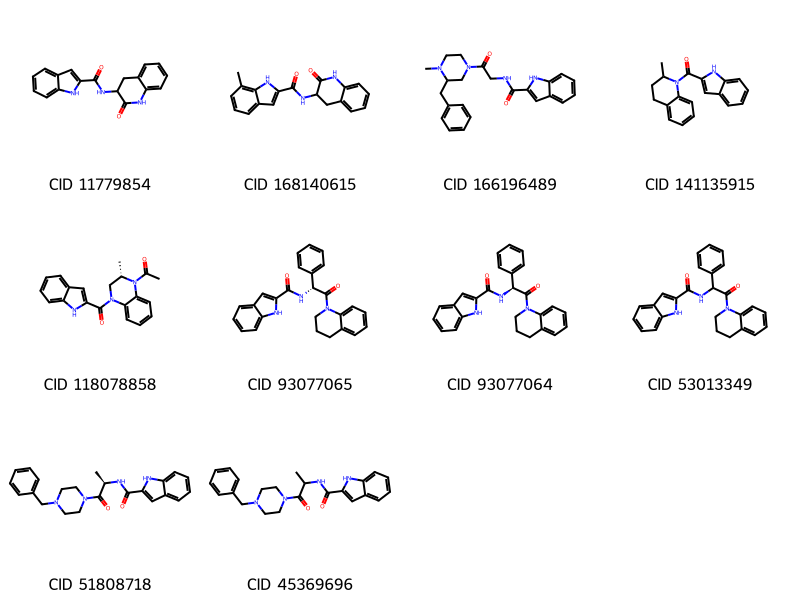

In [34]:
from rdkit import Chem
from rdkit.Chem import Draw

mols = []

for mycid in cids_top :
    
    mysmiles = df[ df.CID==mycid ].SMILES.item()
    
    mol = Chem.MolFromSmiles( mysmiles )
    Chem.FindPotentialStereoBonds(mol)    # Identify potential stereo bonds!
    mols.append(mol)

mylegends = [ "CID " + str(x) for x in cids_top ]
img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200,200), legends=mylegends)
display(img)

An important observation from these images is that the hit list contains multiple compounds with the same connectivity.  For example, CIDs 93077065 and 93077064 are stereoisomers of each other and CID 53013349 has the same connectivity as the two CIDs, but with its stereocenter being unspecified. When performing a screening with limited resources in the early stage of drug discovery, you may want to test as diverse molecules as possible, avoiding testing too similar structures.

To do so, let's look into PubChem's Connectivity SMILES strings, which do not encode the stereochemisry and isotope information.  Chemicals with the same connectivity but with different stereochemistry/isotopes should have the same connectivity SMILES.  In the next section, we select unique compounds in terms of connectivity SMILES to reduce the number of compounds to screen.

## 6. Extract unique compounds in terms of connectivity SMILES

The next few cells show how to get unique values within a column (in this case, unique connectivity SMILES).

In [35]:
# Show the number of rows in the data frame
len(df) 

24321

In [36]:
# Show the number of unique structures in the data frame
len(df.ConnectivitySMILES.unique()) 

19330

In [37]:
# Get unique structures
connectivity_smiles = df.ConnectivitySMILES.unique() 

In [38]:
# Show all the entries for the first unique structure
df[ df.ConnectivitySMILES == connectivity_smiles[0] ] 

,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,ConnectivitySMILES,SMILES,HitFreq
3,9910160,3,4,422.9,4.4,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,3
15,70155849,3,4,422.9,4.4,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,3


In [39]:
# Show all the entries for the second unique structure
df[ df.ConnectivitySMILES == connectivity_smiles[1] ] 

,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,ConnectivitySMILES,SMILES,HitFreq
4,9823695,3,4,424.9,4.6,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,3


In [40]:
# Show all the stereoisomers for the first unique structure
df[ df.ConnectivitySMILES == connectivity_smiles[0] ].SMILES.to_list() 


['CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)NC/C=C/C3=CC=CC=C3',
 'CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)NCC=CC3=CC=CC=C3']

Now let's generate a list of unique compounds in terms of connectivity SMILES.  If multiple compounds have the same connectivity SMILES, the one that appears very first will be included in the unique compound list.

In [41]:
idx_to_include = []

for mysmiles in connectivity_smiles :

    myidx = df[ df.ConnectivitySMILES == mysmiles ].index.to_list()[0]
    
    idx_to_include.append( myidx )

In [42]:
len(idx_to_include)

19330

In [43]:
# Create a new column 'Include' 
# All values initialized to 0 (not include)
df['Include'] = 0 
print(df['Include'].sum()) # Show the total number of included compounds, should be 0 now

0


In [44]:
# Now the "Include" column's value is modified if the record is in the idx_to_include list.
df.loc[idx_to_include,'Include'] = 1 # Set "Include" to 1 for the selected records
print(df['Include'].sum()) # Show the total number of included compounds, should be equal to the number of unique structures

19330


In [45]:
df[['CID','Include']].head(15) # Show the first 15 rows of the "CID" and "Include" columns

,CID,Include
3,9910160,1
4,9823695,1
5,15838575,1
6,15838576,1
7,18318270,1
8,18318274,1
10,18318313,1
11,18318317,1
12,20183492,1
13,70073800,0


Now draw the top 10 unique compounds (in terms of connectivity SMILES). Note the, the structure figures are drawn using isomeric SMILES, but connectivity SMILES strings could be used.

In [46]:
cids_top = df[ df['Include'] == 1].sort_values(by=['HitFreq', 'CID'], ascending=False).head(10).CID.to_list()

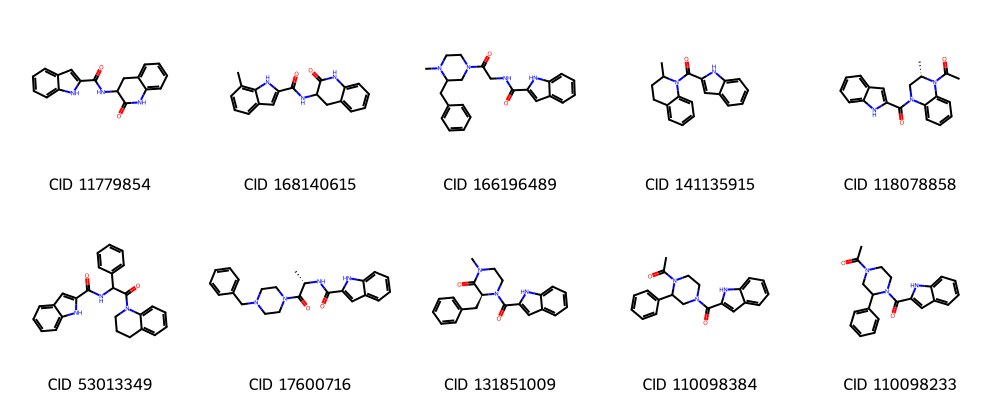

In [47]:
mols = []

for mycid in cids_top :
    
    mysmiles = df[ df.CID==mycid ].SMILES.item()
    
    mol = Chem.MolFromSmiles( mysmiles )
    Chem.FindPotentialStereoBonds(mol)    # Identify potential stereo bonds!
    mols.append(mol)

mylegends = [ "CID " + str(x) for x in cids_top ]
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200), legends=mylegends)
display(img)

<div class="alert alert-block alert-warning">
<Strong>Check Your Understanding</strong>

- Recall from cell [46] that row 15 CID 70155849 is an isomer of row 3. In Cell [55] how do you know this was excluded because it was an isomer?

- Previously we showed CIDs 93077065 and 93077064 are stereoisomers of each other and CID 53013349 has the same connectivity as the two CIDs, but with its stereocenter being unspecified. All three were in our original display of the top 10 unique molecules. Which of these are in our new list?

## 7. Saving molecules in files

Now save the molecules in the cids_top list in files, which will be used in molecular docking experiments.  For simplicity, we will use only the **top 3** compounds in the list.

In [48]:
from rdkit.Chem import AllChem

for idx, mycid in enumerate( cids_top ) :

    if idx == 3 :
        break
        
    mysmiles = df[ df['CID'] == mycid ].SMILES.item()

    mymol = Chem.MolFromSmiles(mysmiles)
    mymol = Chem.AddHs(mymol)
    AllChem.EmbedMolecule(mymol)
    AllChem.MMFFOptimizeMolecule(mymol)

    filename = "pygm_lig" + str(idx) + "_" + str(mycid) + ".mol"
    Chem.MolToMolFile(mymol, filename)


To save all data in the **df** data frame (in CSV) 

In [49]:
df.to_csv('pygm_df.csv')

In [52]:
filepath = make_filename("pygm_df")
df.to_csv(filepath, index=False)


In [54]:
df = pd.read_csv(filepath)
df.head()


,Unnamed: 0,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,ConnectivitySMILES,SMILES,HitFreq,Include
0,3,9910160,3,4,422.9,4.4,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,3,1
1,4,9823695,3,4,424.9,4.6,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,3,1
2,5,15838575,2,6,434.9,3.3,CC1=C(C(C(=C(N1)C)C(=O)OC)C2=CC=CC=C2Cl)C(=O)N...,CC1=C(C(C(=C(N1)C)C(=O)OC)C2=CC=CC=C2Cl)C(=O)N...,3,1
3,6,15838576,2,6,448.9,3.9,CC1=C(C(C(=C(N1)C)C(=O)OC)C2=CC=CC=C2Cl)C(=O)N...,CC1=C(C(C(=C(N1)C)C(=O)OC)C2=CC=CC=C2Cl)C(=O)N...,3,1
4,7,18318270,3,4,410.9,4.2,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,3,1


<div class="alert alert-block alert-success">
<center><H1>Homework</H1></center>

In this activity you used filtered by Lipinski's Rule of Five(Ro5) and saved those molecules in pygm_df.csv. The Ro5 focuses on drug-likeness helping to identify favorable properties for oral bioavailability which is important in the later stages of the drug development pipeline. 

If we are interested in creating a list of molecues that are potentially interesting in the early phases of drug discovery, there is another set of rules that emphasizes "lead-likeness". Leads are molecules that serve as a starting point modify and create drugs for testing. 

Miles Congreve proposed the <a href="https://pubmed.ncbi.nlm.nih.gov/14554012/">"Rule of 3"</a> to create a list of lead like filters rather than drug like filters. 

Congreve’s rule of 3
- The number of hydrogen bond donors ≤3
- The number of hydrogen bond acceptors ≤ 3
- Molecular weight < 300
- XlogP ≤ 3

In [ ]:
# Write your code here


#### Step 1
Load the actives_final.ism for cyclooxygenase-2 (Target Name: PGH2, PDB ID: 3ln1) from the DUD-E database into a pandas DataFrame called df_COX2_act. After loading the data, show the following information:

- the number of rows of the data frame
- the first five rows of the data frame

#### Step 2 
Perform similarity search using each of the isomeric SMILES contained in the loaded data frame.

- As we did for PYGM ligands in this notebook, track the number of times a particular hit is returned from multiple queries, using a dictionary named cids_hit (CIDs as keys and the frequencies as values). This information will be used to rank the hit compounds.
- Make sure that the CIDs are recognized as integers when they are used as keys in the dictionary.
- Print the total number of hits returned from this step (which is the same as the number of CIDs in **cids_hit**).
- Add time.sleep() to avoid overloading PubChem servers.

In [ ]:
# Write your code here


#### Step 3
The hit list from the above step may contain the query compounds themselves. Get the CIDs of the query compounds through idenitity search and remove them from the hit list.

- Set the optional parameter "identity_type" to "same_connectivity".
- Add time.sleep() to avoid overloading PubChem servers.
- Print the number of CIDs corresponding to the query compounds.
- Print the number of the remaining hit compounds, after removing the query compounds from the hit list.

In [ ]:
# Write your code here


#### Step 4
Download the hydrogen donor and acceptor counts, molecular weights, XlogP, and connectivity and isomeric SMILES for each compound in cids_hit. Load the downloaded data into a new data frame called df_COX2_raw. Print the size (or dimension) of the data frame using .shape.

In [ ]:
# Write your code here


#### Step 5
Create a new data frame called df_COX2_combined, which combines the data stored in cids_hit and df_COX2_raw.

- First load the frequency data into a new data frame called df_COX2_freq
- Join df_COX2_raw and df_COX2_freq into df_COX2_combined
- Print the shape (dimension) of df_COX2_combined

In [ ]:
# Write your code here


#### Step 6
Remove from df_COX2_combined **all** compounds that violate **any** criterion of Congreve's rule of 3 and show the number of remaining compounds.

In [ ]:
# Write your code here


#### Step 7
Get the unique connectivity SMILES strings from the df_COX2_combined. Add to df_COX2_combined a column named 'Include', which contains a flag set to 1 for the lowest CID associated with each unique CID and set to 0 for other CIDs. Show the number of compounds for which this flag is set to 1.

In [ ]:
# Write your code here


#### Step 8
Among those with the "Include" flag set to 1, identify the top 10 compounds that were returned from the largest number of query compounds.

- Sort the data frame by the number of times returned (in descending order) and then by CID (in ascending order)
- For each of the 10 compounds, print its CID, isomeric SMILES, and the number of times it was returned.
- For each of the 10 compounds, draw its structure (using isomeric SMILES).



In [ ]:
# Write your code here



#### Step 9
Now save the **top 3** compounds with CID and SMILES in a file called COX2_congreve.csv. 

In [ ]:
# Write your code here
